In [1]:
import tensorflow.compat.v2 as tf
print(tf.__version__)
# 2.1.0

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

2.1.0


In [2]:
#MobileNetV2: Inverted Residuals and Linear Bottlenecks
# https://arxiv.org/abs/1801.04381
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')

# labels in the imagenet: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

#We are not training any model parameters
pretrained_model.trainable = False

# ImageNet labels
#These map the class integers to the actual class names in the pre-defined models.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

(1000, 1000, 3)


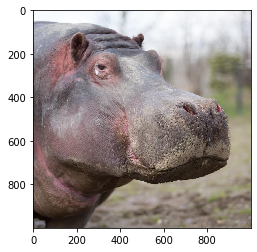

In [3]:
hippo = cv2.imread('images/hippo.jpg')
hippo = cv2.cvtColor(hippo, cv2.COLOR_BGR2RGB)
plt.imshow(hippo)

print(hippo.shape)

In [4]:
#Cast, normalize and resize the image
image = tf.cast(hippo, tf.float32)
image = image/255
image = tf.image.resize(image, (224, 224))
image = image[None, ...]
#<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32> # 1 image of size (224, 224, 3)

In [5]:
image_probs = pretrained_model.predict(image,steps=1)
#(1, 1000)
prediction = decode_predictions(image_probs, top=1)[0][0]
#('n02398521', 'hippopotamus', 0.8922553)

class_probability = decode_predictions(image_probs, top=1)[0][0][2]
#0.8922553

image_class = decode_predictions(image_probs, top=1)[0][0][1]
#'hippopotamus'

# Iterative least-likely class attack 

https://arxiv.org/abs/1607.02533

![](images/less_likely1.png)
![](images/less_likely2.png)


**NOTE**:

This update is nearly identical to equation in iterative-FGSM, except that the predicted class in the cross-entropy loss is changed from the true label to an adversarial target, and the sign of the gradient update is reversed because this time attack is targeted. We want to reduce the loss of adversarial training pair to misguide the model into having excessive confidence towards the targetted class.

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [7]:
less_likely_class_index = image_probs.argmin()
#104
#104: 'wallaby, brush kangaroo'

label = tf.one_hot(less_likely_class_index, image_probs.shape[-1])
#<tf.Tensor 'one_hot:0' shape=(1000,) dtype=float32>

label = tf.reshape(label, (1, image_probs.shape[-1]))
#<tf.Tensor 'Reshape:0' shape=(1, 1000) dtype=float32>

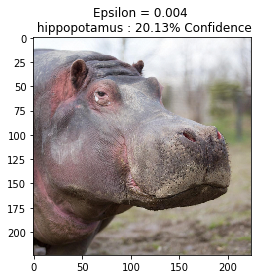

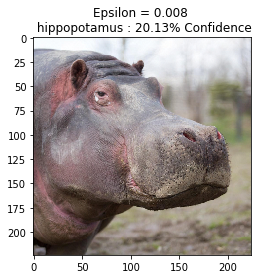

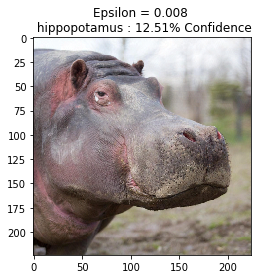

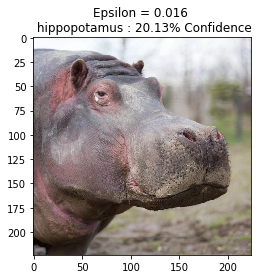

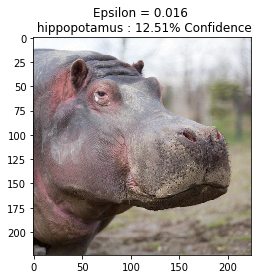

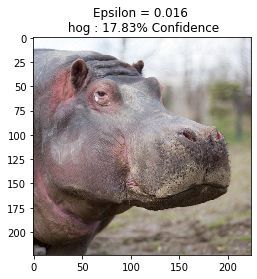

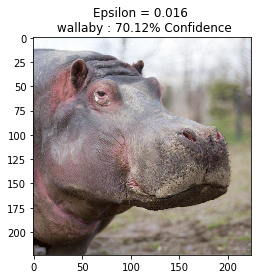

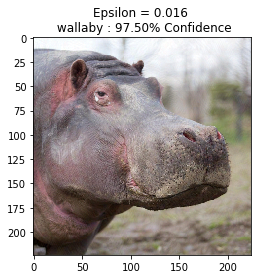

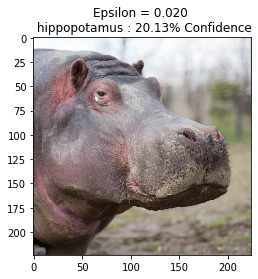

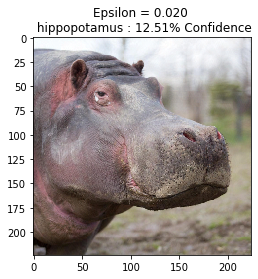

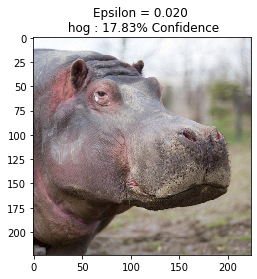

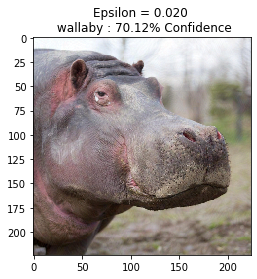

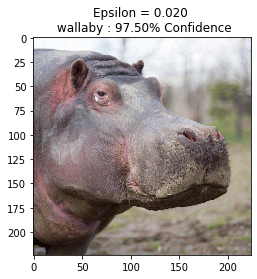

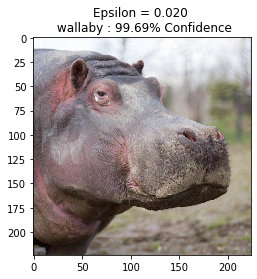

In [8]:
alpha = 1
epsilons = [0/255, 1/255, 2/255, 4/255, 5/255]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

alpha = 1/255 #paper uses alpha = 1 but we have normalized image

for i, eps in enumerate(epsilons):
    adv_x = image
    #The paper said min(eps + 4, 1.25*eps) is used as iterations
    iters = int(min(eps*255 + 4, 1.25*eps*255))
    for j in range(iters):
        perturbations = create_adversarial_pattern(adv_x, label)
        
        # attack is targeted, minimize loss of target label rather than maximize loss of correct label
        adv_x = adv_x - alpha * perturbations
        adv_x = tf.clip_by_value(adv_x, clip_value_min= tf.math.maximum(0, tf.subtract(adv_x, eps)), clip_value_max=tf.math.minimum(1, tf.add(adv_x, eps))) 
        _, label_string, confidence = decode_predictions(pretrained_model.predict(adv_x), top=1)[0][0]
        plt.figure()
        plt.imshow(adv_x[0])
        plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label_string, confidence*100))
        plt.show()